# Data Wrangling and Analyzing


## Our goal: 
Real-world data rarely comes clean. Using Python and its libraries, we will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. We will document our wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

### Load necessary modules

In [339]:
# Import necessary modules
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import time
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime
%matplotlib inline
import twitter_credentials

### Source#1: Given Archived Data
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. We'll need to assess and clean these columns if we want to use them for analysis and visualization.

In [2]:
# load the twitter-archive-enhanced.csv into a DataFrame
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [3]:
twitter_archive.shape

(2356, 17)

### Source#2: Image Predictions File

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
 

In [6]:
# Download the image prediction file using the link provided to Udacity students
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_request = requests.get(url, allow_redirects=True)

with open('image_predictions.tsv', 'wb') as f:
    f.write(image_request.content)

In [7]:
# load the image predictions data into a DataFrame
predictions = pd.read_csv('image-predictions.tsv', sep='\t')
predictions.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [8]:
predictions.shape

(2075, 12)

### Source#3:Additional Data via the Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. Because we have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? We're going to query Twitter's API to gather this valuable data.

In [18]:
#source: https://github.com/vprusso/youtube_tutorials/blob/master/twitter_python/part_3_analyzing_tweet_data/analyzing_twitter_data.py
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth
    
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = tweepy.API(self.auth, parser=tweepy.parsers.JSONParser())

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

In [19]:
twitter_client = TwitterClient()
api = twitter_client.get_twitter_client_api()

In [20]:
# Source: https://github.com/chelseymarie6/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb
# Query Twitter's API for JSON data - match to each Tweet ID from the archive

# this starts the timer
start = time.time()

tweet_ids = twitter_archive.tweet_id.values

tweets_data = []
tweet_success = []
tweet_failure = []

for tweet_id in tweet_ids:
        try:
            data = api.get_status(tweet_id, tweet_mode='extended', 
                                  wait_on_rate_limit = True, 
                                  wait_on_rate_limit_notify = True)
            tweets_data.append(data)
            tweet_success.append(tweet_id)
        except:
            tweet_failure.append(tweet_id)
            print(tweet_id)

# this stops the timer            
end = time.time()

print(end - start)

888202515573088257
873697596434513921
872668790621863937
872261713294495745
869988702071779329
866816280283807744
861769973181624320
856602993587888130
851953902622658560
845459076796616705
844704788403113984
842892208864923648
837366284874571778
837012587749474308


Rate limit reached. Sleeping for: 42


829374341691346946
827228250799742977
812747805718642688
802247111496568832
779123168116150273
775096608509886464
771004394259247104
770743923962707968
759566828574212096
754011816964026368


Rate limit reached. Sleeping for: 545


680055455951884288


Rate limit reached. Sleeping for: 516


2085.6717851161957


In [21]:
tweets_data

[{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
  'id': 892420643555336193,
  'id_str': '892420643555336193',
  'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
  'truncated': False,
  'display_text_range': [0, 85],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 892420639486877696,
     'id_str': '892420639486877696',
     'indices': [86, 109],
     'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'url': 'https://t.co/MgUWQ76dJU',
     'display_url': 'pic.twitter.com/MgUWQ76dJU',
     'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
     'type': 'photo',
     'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
      'small': {'w': 540, 'h': 528, 'resize': 'fit'}

In [22]:
# Store data to tweet_json.txt
with open('tweet_json.txt', mode = 'w') as file:
    json.dump(tweets_data, file)

In [26]:
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, fetched_tweets_filename):
        df = pd.read_json(fetched_tweets_filename)
        df = df[['id', 'favorite_count', 'retweet_count']]
        return df

In [27]:
tweet_analyzer = TweetAnalyzer()
counts_df = tweet_analyzer.tweets_to_data_frame('tweet_json.txt')
counts_df.head()

id  favorite_count  retweet_count
0  892420643555336193           36292           7724
1  892177421306343426           31287           5714
2  891815181378084864           23563           3786
3  891689557279858688           39580           7877
4  891327558926688256           37785           8503

In [29]:
counts_df.to_csv('tweet_counts.csv',index=False)

### Assessment
This section will go over the following:

* Quality Issues
* Tidiness Issues

#### Quality Issues

The four main data quality dimensions are:

1. Completeness: missing data
1. Validity: data making sense
1. Accuracy: inaccurate data
1. Consistency: standardization

#### Tidiness Issues

Three requirements for tidiness:

1. Each variable forms a column
1. Each observation forms a row
1. Each type of observational unit forms a table


### Visual Quality Assessment

#### `twitter_archive`:

1. Completeness:
    * missing data in the following columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls
1. Validity:
    * dog names: some dogs have 'None','a' as a name
1. Accuracy:
    * rating_denominator should be a standard 10, but there are some other values
    * some rating values might be inaccurate 
1. Consistency:
    * the source column has the HTML tags
    * some retweets are present in the data
    
#### `predictions`:

1. Validity:
    * p1, p2 and p3 columns have invalid data...such as shopping_cart, deshtop_computer (among other things)?
1. Consistency:
    * p1, p2 and p3 columns aren't consistent when it comes to capitalization
    * p1, p2 and p3 columns there is an underscore for multi-word dog breeds
    
#### `counts_df`:
1. Completeness:
    * There are some missing tweets while we try to acceess them by API
    
### Visual Tidyiness Assessment

#### `twitter_archive``:
* The last four columns all relate to the same variable (dogoo, floofer, pupper, puppo)
* Some columns are unnecessary

#### `predictions`:
* this data set is part of the same observational unit as the data in the `twitter_archive` 
* Need two columns for dog's breed and prediction confidence

#### `counts_df`:
* this data set is also part of the same observational unit as the data in the `twitter_archive`

### Programmatic Assessment

In [30]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Quailty Issues in `twitter_archive`
* Completeness:
missing data in the following columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`
* Accuracy:
`timestamp` is an object,`tweet_id` is integer 

In [32]:
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [31]:
twitter_archive.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

#### Quality issues in `twitter_archive`
* Accuracy:
rating_denominator should be a standard 10, but there is a max value of 170

In [34]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### Quality issues in `twitter_archive`
* Accuracy:
rating_denominator should be a standard 10, but there are some other values 

In [56]:
twitter_archive.tweet_id.duplicated().sum()

0

There is no duplicated `tweet id` in `twitter_archive`

In [80]:
twitter_archive['name'].value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
my           1
Stella       1
Emanuel      1
Pumpkin      1
Blanket      1
Name: name, Length: 957, dtype: int64

#### Quality Issue in `twitter_archive`
Validity:
dog names: some dogs have 'None','a','my' as a name

In [39]:
tweet_failure

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 759566828574212096,
 754011816964026368,
 680055455951884288]

In [47]:
twitter_archive[twitter_archive.tweet_id.isin(tweet_failure)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19    888202515573088257                    NaN                  NaN   
95    873697596434513921                    NaN                  NaN   
101   872668790621863937                    NaN                  NaN   
104   872261713294495745                    NaN                  NaN   
118   869988702071779329                    NaN                  NaN   
132   866816280283807744                    NaN                  NaN   
155   861769973181624320                    NaN                  NaN   
182   856602993587888130                    NaN                  NaN   
211   851953902622658560                    NaN                  NaN   
247   845459076796616705                    NaN                  NaN   
253   844704788403113984                    NaN                  NaN   
260   842892208864923648                    NaN                  NaN   
296   837366284874571778                    NaN                  NaN   
298   837012587749474308                    NaN                  NaN   
363   829374341691346946                    NaN                  NaN   
382   827228250799742977                    NaN                  NaN   
506   812747805718642688                    NaN                  NaN   
566   802247111496568832                    NaN                  NaN   
750   779123168116150273                    NaN                  NaN   
784   775096608509886464                    NaN                  NaN   
815   771004394259247104                    NaN                  NaN   
818   770743923962707968                    NaN                  NaN   
890   759566828574212096                    NaN                  NaN   
932   754011816964026368                    NaN                  NaN   
1726  680055455951884288                    NaN                  NaN   

                      timestamp  \
19    2017-07-21 01:02:36 +0000   
95    2017-06-11 00:25:14 +0000   
101   2017-06-08 04:17:07 +0000   
104   2017-06-07 01:19:32 +0000   
118   2017-05-31 18:47:24 +0000   
132   2017-05-23 00:41:20 +0000   
155   2017-05-09 02:29:07 +0000   
182   2017-04-24 20:17:23 +0000   
211   2017-04-12 00:23:33 +0000   
247   2017-03-25 02:15:26 +0000   
253   2017-03-23 00:18:10 +0000   
260   2017-03-18 00:15:37 +0000   
296   2017-03-02 18:17:34 +0000   
298   2017-03-01 18:52:06 +0000   
363   2017-02-08 17:00:26 +0000   
382   2017-02-02 18:52:38 +0000   
506   2016-12-24 19:52:31 +0000   
566   2016-11-25 20:26:31 +0000   
750   2016-09-23 01:00:13 +0000   
784   2016-09-11 22:20:06 +0000   
815   2016-08-31 15:19:06 +0000   
818   2016-08-30 22:04:05 +0000   
890   2016-07-31 01:50:18 +0000   
932   2016-07-15 17:56:40 +0000   
1726  2015-12-24 16:00:30 +0000   

                                                 source  \
19    <a href="http://twitter.com/download/iphone" r...   
95    <a href="http://twitter.com/download/iphone" r...   
101   <a href="http://twitter.com/download/iphone" r...   
104   <a href="http://twitter.com/download/iphone" r...   
118   <a href="http://twitter.com/download/iphone" r...   
132   <a href="http://twitter.com/download/iphone" r...   
155   <a href="http://twitter.com/download/iphone" r...   
182   <a href="http://twitter.com/download/iphone" r...   
211   <a href="http://twitter.com/download/iphone" r...   
247   <a href="http://twitter.com/download/iphone" r...   
253   <a href="http://twitter.com/download/iphone" r...   
260   <a href="http://twitter.com/download/iphone" r...   
296   <a href="http://twitter.com/download/iphone" r...   
298   <a href="http://twitter.com/download/iphone" r...   
363   <a href="http://twitter.com/download/iphone" r...   
382   <a href="http://twitter.com/download/iphone" r...   
506   <a href="http://twitter.com/download/iphone" r...   
566   <a href="http://twitter.com/download/iphone" r...   
750   <a href="http://twitter.com/download/iphone" r...   
784   <a href="http://twitter.com/download/iphone" r

In [53]:
api.get_status(680055455951884288, tweet_mode='extended', 
                                  wait_on_rate_limit = True, 
                                  wait_on_rate_limit_notify = True)

TweepError: [{'code': 144, 'message': 'No status found with that ID.'}]

#### Quality Issue in `counts_df`:
Completeness:
There are some missing tweets while we try to acceess them by API. Many of them are reweets but a few of them are valid tweets

In [60]:
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [61]:
counts_df.describe()

id  favorite_count  retweet_count
count  2.331000e+03     2331.000000    2331.000000
mean   7.419079e+17     7577.434148    2711.052338
std    6.823170e+16    11758.733949    4584.911364
min    6.660209e+17        0.000000       1.000000
25%    6.782670e+17     1322.000000     548.500000
50%    7.182469e+17     3298.000000    1272.000000
75%    7.986692e+17     9284.000000    3150.500000
max    8.924206e+17   156588.000000   78043.000000

In [63]:
counts_df.id.duplicated().sum()

0

There is no duplicate `id` in `counts_df`

In [54]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [65]:
predictions.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [66]:
predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [55]:
predictions.tweet_id.duplicated().sum()

0

There is no duplicated `tweet_id` in `predictions`

In [57]:
predictions['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
water_buffalo           1
barbell                 1
limousine               1
trombone                1
Name: p1, Length: 378, dtype: int64

In [58]:
predictions['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
bearskin                1
peacock                 1
jigsaw_puzzle           1
wallaby                 1
trench_coat             1
Name: p2, Length: 405, dtype: int64

In [59]:
predictions['p3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
gar                    1
ibex                   1
green_lizard           1
pretzel                1
cloak                  1
Name: p3, Length: 408, dtype: int64

#### Quality issues in `predictions`
* Validity:
p1, p2 and p3 columns have invalid data...such as pillow, barbell (among other things)?
* Consistency:
p1, p2 and p3 columns aren't consistent when it comes to capitalization


### Clean
This section consists of the cleaning portion of the data wrangling process:

1. Define
1. Code
1. Test

In [264]:
# Make a copy of the tables before cleaning
archive_clean = twitter_archive.copy()
predictions_clean = predictions.copy()
counts_clean = counts_df.copy()

#### Tidiness Issue#1
* Define: Merge the clean versions of archive, predictions, and counts dataframes
* Code

In [265]:
#Source: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
from functools import reduce
counts_clean.rename(columns={'id':'tweet_id'},inplace=True)
dfs = [archive_clean, predictions_clean, counts_clean]
twitter_dogs = reduce(lambda left, right:  pd.merge(left, right, on = 'tweet_id'), dfs)

#### Tidiness Issue#1
* Define: Merge the clean versions of archive, predictions, and counts dataframes
* Test

In [266]:
twitter_dogs.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  ...   p1_conf  p1_dog  \
0  https://twitter.com/dog_rates/status/892420643...  ...  0.097049   False   
1  https://twitter.com/dog_rates/status/892177421...  ...  0.323581    True   
2  https://twitter.com/dog_rates/status/891815181...  ...  0.716012    True   
3  https://twitter.com/dog_rates/status/891689557...  ...  0.170278   False   
4  https://twitter.com/dog_rates/status/891327558...  ...  0.555712    True   

                   p2   p2_conf p2_dog                           p3   p3_conf  \
0               bagel  0.085851  False                       banana  0.076110   
1            Pekinese  0.090647   True                     papillon  0.068957   
2            malamute  0.078253   True                       kelpie  0.031379   
3  Labrador_retriever  0.168086   True                      spatula  0.040836   
4    English_springer  0.225770   True  German_short-haired_pointer  0.175219   

  p3_dog  favorite_count retweet_count  
0  False           36292          7724  
1   True           31287          5714  
2   True           23563          3786  
3  False           39580          7877  
4   True           37785          8503  

[5 rows x 30 columns]

In [267]:
twitter_dogs.shape

(2059, 30)

In [268]:
twitter_dogs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count'],
      dtype='object')

#### Tidiness Issue#2
* Define: Create one column for the various dog types: doggo, floofer, pupper, puppo
* Code

In [269]:
twitter_dogs['dog_stage']=twitter_dogs['doggo'].str.cat(twitter_dogs['floofer'],sep=" ") \
.str.cat(twitter_dogs['pupper'],sep=" ") \
.str.cat(twitter_dogs['puppo'],sep=" ") \
.str.replace('None','').str.strip().str.replace(' +',' ')


In [270]:
for i, text in twitter_dogs['dog_stage'].iteritems():
    if text=="":
        twitter_dogs['dog_stage'][i]="None"


C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Tidiness Issue#2
* Define: Create one column for the various dog types: doggo, floofer, pupper, puppo
* Test

In [271]:
twitter_dogs.dog_stage.value_counts()

None             1741
pupper            210
doggo              65
puppo              23
doggo pupper       11
floofer             7
doggo puppo         1
doggo floofer       1
Name: dog_stage, dtype: int64

#### Quaility Issue#1: 
* Define: Delete retweets in `twitter_dogs`
* Code

In [272]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
doggo                         2059 non-null object
floofer                       2059 non-null object
pupper                        2059 non-null object
puppo                         2059 non-null object
jpg_url                       2059 

In [273]:
# Retweet have a non-null `retweet_status id`
# Keep the columns where retweeted_status_id is NaN
twitter_dogs = twitter_dogs[np.isnan(twitter_dogs.retweeted_status_id)]

#### Quaility Issue#1: 
* Define: Delete retweets in `twitter_dogs`
* Test

In [274]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                       1987 non

#### Quaility Issue#2: 
* Define: Convert `timestamp` from `string` to `datatime`
* Code

In [275]:
# Change the 'timestamp' column to a datetime object
twitter_dogs['timestamp'] = pd.to_datetime(twitter_dogs['timestamp'], format = "%Y-%m-%d %H:%M:%S")

#### Quaility Issue#2: 
* Define: Convert `timestamp` from `string` to `datatime`
* Test

In [276]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null datetime64[ns, UTC]
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                  

In [277]:
twitter_dogs.head()


tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                  timestamp  \
0 2017-08-01 16:23:56+00:00   
1 2017-08-01 00:17:27+00:00   
2 2017-07-31 00:18:03+00:00   
3 2017-07-30 15:58:51+00:00   
4 2017-07-29 16:00:24+00:00   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  ...  p1_dog  \
0  https://twitter.com/dog_rates/status/892420643...  ...   False   
1  https://twitter.com/dog_rates/status/892177421...  ...    True   
2  https://twitter.com/dog_rates/status/891815181...  ...    True   
3  https://twitter.com/dog_rates/status/891689557...  ...   False   
4  https://twitter.com/dog_rates/status/891327558...  ...    True   

                   p2   p2_conf p2_dog                           p3   p3_conf  \
0               bagel  0.085851  False                       banana  0.076110   
1            Pekinese  0.090647   True                     papillon  0.068957   
2            malamute  0.078253   True                       kelpie  0.031379   
3  Labrador_retriever  0.168086   True                      spatula  0.040836   
4    English_springer  0.225770   True  German_short-haired_pointer  0.175219   

  p3_dog favorite_count  retweet_count dog_stage  
0  False          36292           7724      None  
1   True          31287           5714      None  
2   True          23563           3786      None  
3  False          39580           7877      None  
4   True          37785           8503      None  

[5 rows x 31 columns]

#### Quaility Issue#3: 
* Define: Convert the lowercase names to `None`
* Code

In [278]:
# Replace the lowercase names to None
twitter_dogs.name = twitter_dogs.name.str.replace('^[a-z]+', 'None')

#### Quaility Issue#3: 
* Define: Convert the lowercase names to `None`
* Test

In [279]:
twitter_dogs.name.value_counts()

None         644
Charlie       10
Oliver        10
Cooper        10
Tucker         9
            ... 
Suki           1
Meyer          1
Sprinkles      1
Mya            1
Blanket        1
Name: name, Length: 912, dtype: int64

#### Quaility Issue#4: 
* Define: Delete row with the `rating_denominator` of an invalid value
* Code

In [280]:
twitter_dogs.rating_denominator.value_counts()

10     1969
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [281]:
# keep rows with vaid denominator rating=10
twitter_dogs=twitter_dogs[twitter_dogs.rating_denominator==10]

#### Quaility Issue#4: 
* Define: Delete row with the `rating_denominator` of an invalid value
* Test

In [282]:
twitter_dogs.rating_denominator.value_counts()

10    1969
Name: rating_denominator, dtype: int64

#### Quaility Issue#5: 
* Define: Convert `rating_numerator` to float
* Code

In [283]:
twitter_dogs['rating_numerator'] = twitter_dogs['rating_numerator'].astype(float)

#### Quaility Issue#5: 
* Define: Convert `rating_numerator` to float
* Test

In [284]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1969 non-null int64
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     1969 non-null datetime64[ns, UTC]
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null float64
rating_denominator            1969 non-null int64
name                          1969 non-null object
doggo                         1969 non-null object
floofer                       1969 non-null object
pupper                        1969 non-null object
puppo                         1969 non-null object
jpg_url                

#### Quaility Issue#6: 
* Define: Correct the inaccurate `rating_numberator` by extracting the correct fractional rating value
* Code

In [285]:
index=[]
for i, text in twitter_dogs['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        twitter_dogs['rating_numerator'][i]=float(re.search('\d+\.\d+', text).group())
        index.append(i)

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Quaility Issue#6: 
* Define: Correct the inaccurate `rating_numberator` by extracting the correct fractional value
* Test

In [286]:
for i in index:
    print(twitter_dogs['text'][i], twitter_dogs['rating_numerator'][i])

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 13.5
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 9.75
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq 11.27
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD 11.26


#### Quaility Issue#7: 
* Define: Change `tweet_id` from an integer to a string
* Code

In [287]:
# Convert to string
twitter_dogs['tweet_id'] = twitter_dogs['tweet_id'].astype(str)

#### Quaility Issue#7: 
* Define: Change `tweet_id` from an integer to a string
* Test

In [288]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1969 non-null object
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     1969 non-null datetime64[ns, UTC]
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null float64
rating_denominator            1969 non-null int64
name                          1969 non-null object
doggo                         1969 non-null object
floofer                       1969 non-null object
pupper                        1969 non-null object
puppo                         1969 non-null object
jpg_url               

#### Quaility Issue#8: 
* Define: Remove the html tags from `source`, only keep the content inside the tags
* Code

In [289]:
twitter_dogs.source[0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [306]:
# Source: https://www.youtube.com/watch?v=K8L6KVGG-7o
import re
pattern=re.compile(r'(<a href="https?)(:\/\/)(.+)(">)(.+)(<\/a>)')
for i, text in twitter_dogs['source'].iteritems():
    matches=pattern.finditer(text)
    for match in matches:
        twitter_dogs['source'][i]=match.group(5)

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Quaility Issue#8: 
* Define: Remove the html tags from `source`, only keep the content inside the tags
* Test

In [307]:
twitter_dogs.source.value_counts()

Twitter for iPhone    1931
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### Tidiness Issue#3:¶
* Define: Extract dog breed and prediction confidence into two columns
* Code

In [311]:
#Source: https://github.com/StefaniePowazny/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb
# write a function that extracts the first dog breed prediction from the predictions DataFrame
def breed(row):
    if row['p1_dog']:
        return(row['p1'])
    elif row['p2_dog']:
        return(row['p2'])
    elif row['p3_dog']:
        return(row['p3'])
    else:
        return(np.NaN)

In [312]:
#Source: https://github.com/StefaniePowazny/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb
# apply the breed function to the clean DataFrame to create a new column 'breed_pred'
twitter_dogs['breed_pred'] = twitter_dogs.apply (lambda row: breed (row),axis=1)

In [313]:
#Source: https://github.com/StefaniePowazny/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb
# write a function that extracts the confidence for the first dog breed prediction from the predictions DataFrame
def confidence(row):
    if row['p1_dog']:
        return(row['p1_conf'])
    elif row['p2_dog']:
        return(row['p2_conf'])
    elif row['p3_dog']:
        return(row['p3_conf'])
    else:
        return(np.NaN)

In [314]:
#Source: https://github.com/StefaniePowazny/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb
# apply the confidence function to the clean DataFrame to create a new column 'pred_confidence'
twitter_dogs['pred_confidence'] = twitter_dogs.apply (lambda row: confidence(row),axis=1)

#### Tidiness Issue#3:¶
* Define: Extract dog breed and prediction confidence into two columns
* Test

In [315]:
twitter_dogs[['breed_pred','pred_confidence']].head()

breed_pred  pred_confidence
0                 NaN              NaN
1           Chihuahua         0.323581
2           Chihuahua         0.716012
3  Labrador_retriever         0.168086
4              basset         0.555712

In [316]:
twitter_dogs.breed_pred.value_counts()

golden_retriever      154
Labrador_retriever    103
Pembroke               95
Chihuahua              90
pug                    62
                     ... 
Japanese_spaniel        1
standard_schnauzer      1
silky_terrier           1
Irish_wolfhound         1
EntleBucher             1
Name: breed_pred, Length: 113, dtype: int64

#### Quaility Issue#9: 
* Define: Remove underscore from `breed_pred`, make all title case
* Code

In [327]:
for i, text in twitter_dogs['breed_pred'].iteritems():
    if text is not np.nan:
        twitter_dogs['breed_pred'][i]=text.title().replace("_"," ")

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Quaility Issue#9: 
* Define: Remove underscore from `breed_pred`, make all title case
* Test

In [333]:
twitter_dogs['breed_pred'].head()

0                   NaN
1             Chihuahua
2             Chihuahua
3    Labrador Retriever
4                Basset
Name: breed_pred, dtype: object

In [334]:
twitter_dogs['breed_pred'].value_counts()

Golden Retriever        154
Labrador Retriever      103
Pembroke                 95
Chihuahua                90
Pug                      62
                       ... 
Bouvier Des Flandres      1
Entlebucher               1
Irish Wolfhound           1
Clumber                   1
Standard Schnauzer        1
Name: breed_pred, Length: 113, dtype: int64

#### Tidiness Issue#4: 
* Define: Drop unnecessary columns
* Code

In [308]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1969 non-null object
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     1969 non-null datetime64[ns, UTC]
source                        1969 non-null object
text                          1969 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1969 non-null object
rating_numerator              1969 non-null float64
rating_denominator            1969 non-null int64
name                          1969 non-null object
doggo                         1969 non-null object
floofer                       1969 non-null object
pupper                        1969 non-null object
puppo                         1969 non-null object
jpg_url               

In [309]:
twitter_dogs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count',
       'dog_stage'],
      dtype='object')

In [335]:
twitter_dogs.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp','doggo', 'floofer', 'pupper', 'puppo','p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],axis=1,inplace=True)

#### Tidiness Issue#4: 
* Define: Drop unnecessary columns
* Test

In [336]:
twitter_dogs.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'favorite_count', 'retweet_count', 'dog_stage', 'breed_pred',
       'pred_confidence'],
      dtype='object')

In [337]:
twitter_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 2058
Data columns (total 15 columns):
tweet_id              1969 non-null object
timestamp             1969 non-null datetime64[ns, UTC]
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1969 non-null object
jpg_url               1969 non-null object
img_num               1969 non-null int64
favorite_count        1969 non-null int64
retweet_count         1969 non-null int64
dog_stage             1969 non-null object
breed_pred            1662 non-null object
pred_confidence       1662 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(4), object(8)
memory usage: 326.1+ KB


### Saving Cleaned Dataset

In [338]:
# Storing the new twitter_dogs df to a new csv file
twitter_dogs.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

### Storing, Analyzing, and Visualizing Data¶
This section provides an analysis of the data set, and corresponding visualizations to draw valuable conclusions.

1. Visualizing the total number of tweets over time to see whether that number increases, or decreases, over time.
1. Visualizing the retweet counts, and favorite counts comparison over time.
1. Comparison of tweets according to sources
1. Visualizing the most popular dog breed
1. Visualizing the most popular dog names

In [340]:
df=pd.read_csv('twitter_archive_master.csv')
df.head()

tweet_id                  timestamp              source  \
0  892420643555336193  2017-08-01 16:23:56+00:00  Twitter for iPhone   
1  892177421306343426  2017-08-01 00:17:27+00:00  Twitter for iPhone   
2  891815181378084864  2017-07-31 00:18:03+00:00  Twitter for iPhone   
3  891689557279858688  2017-07-30 15:58:51+00:00  Twitter for iPhone   
4  891327558926688256  2017-07-29 16:00:24+00:00  Twitter for iPhone   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   
3  This is Darla. She commenced a snooze mid meal...   
4  This is Franklin. He would like you to stop ca...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   
3  https://twitter.com/dog_rates/status/891689557...              13.0   
4  https://twitter.com/dog_rates/status/891327558...              12.0   

   rating_denominator      name  \
0                  10   Phineas   
1                  10     Tilly   
2                  10    Archie   
3                  10     Darla   
4                  10  Franklin   

                                           jpg_url  img_num  favorite_count  \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg        1           36292   
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg        1           31287   
2  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg        1           23563   
3  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg        1           39580   
4  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg        2           37785   

   retweet_count dog_stage          breed_pred  pred_confidence  
0           7724      None                 NaN              NaN  
1           5714      None           Chihuahua         0.323581  
2           3786      None           Chihuahua         0.716012  
3           7877      None  Labrador Retriever         0.168086  
4           8503      None              Basset         0.555712

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
tweet_id              1969 non-null int64
timestamp             1969 non-null object
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1969 non-null object
jpg_url               1969 non-null object
img_num               1969 non-null int64
favorite_count        1969 non-null int64
retweet_count         1969 non-null int64
dog_stage             1969 non-null object
breed_pred            1662 non-null object
pred_confidence       1662 non-null float64
dtypes: float64(2), int64(5), object(8)
memory usage: 230.9+ KB


In [343]:
# Change the 'timestamp' column to a datetime object again
df['timestamp'] = pd.to_datetime(df['timestamp'], format = "%Y-%m-%d %H:%M:%S")

Text(0, 0.5, 'Number of Tweets')

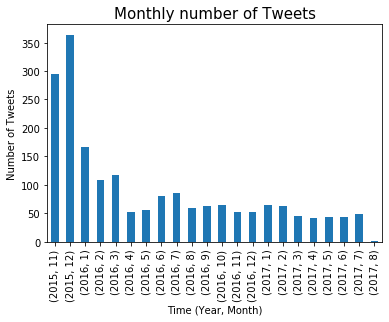

In [348]:
selected_data = df['tweet_id'].groupby([df['timestamp'].dt.year, df['timestamp'].dt.month]).count()
selected_data.plot(kind='bar')
plt.title('Monthly number of Tweets', size=15)
plt.xlabel('Time (Year, Month)')
plt.ylabel('Number of Tweets')

### Observation: 
Monthly number of tweets decreased over time. Initially it was around 300 tweets per month, but presently it hovers around 50 tweets per month.

Text(0, 0.5, 'Number of Retweets')

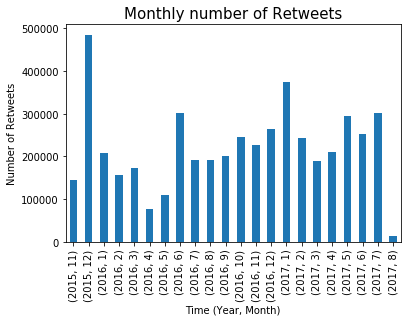

In [350]:
selected_data = df['retweet_count'].groupby([df['timestamp'].dt.year, df['timestamp'].dt.month]).sum()
selected_data.plot(kind='bar');
plt.title('Monthly number of Retweets', size=15)
plt.xlabel('Time (Year, Month)')
plt.ylabel('Number of Retweets')

Text(0, 0.5, 'Number of Likes')

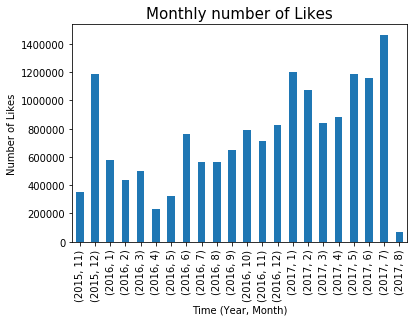

In [351]:
selected_data = df['favorite_count'].groupby([df['timestamp'].dt.year, df['timestamp'].dt.month]).sum()
selected_data.plot(kind='bar');
plt.title('Monthly number of Likes', size=15)
plt.xlabel('Time (Year, Month)')
plt.ylabel('Number of Likes')

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


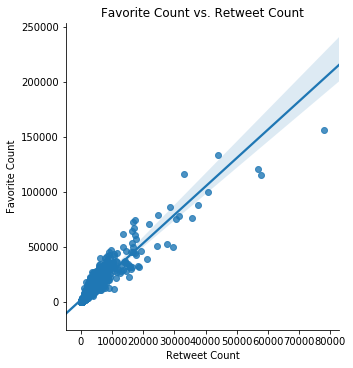

In [352]:
# Scatterplot of retweets vs favorite count
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=df);

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

### Observation:
There is a positive correlation between favorite counts and retweet counts

In [353]:
df.source.value_counts()

Twitter for iPhone    1931
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

In [355]:
iphone = df[df['source'] == "Twitter for iPhone"]['tweet_id'].count()
web = df[df['source'] == "Twitter Web Client"]['tweet_id'].count()
deck= df[df['source'] == "TweetDeck"]['tweet_id'].count()
iphone_prop = iphone / df['tweet_id'].count()
web_prop = web / df['tweet_id'].count()
deck_prop = deck / df['tweet_id'].count()

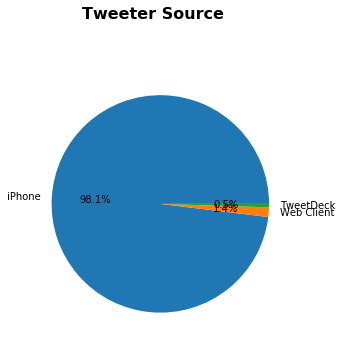

In [359]:
labels = 'iPhone', 'Web Client', 'TweetDeck'

plt.figure(figsize = [8, 5])
prop = [iphone_prop,web_prop,deck_prop]
plt.pie(prop, labels=labels, autopct='%1.1f%%', shadow=False)
plt.suptitle('Tweeter Source', y=1.05, fontsize=16, fontweight='bold');

### Observation:
Majority of the tweets is generated by iPhone (around 98.1%)

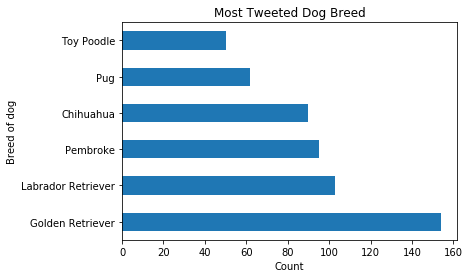

In [366]:
# Histogram to visualize dog breeeds
breed = df.groupby('breed_pred').filter(lambda x: len(x) >= 50)
breed['breed_pred'].value_counts().plot(kind = 'barh')
plt.title('Most Tweeted Dog Breed')
plt.xlabel('Count')
plt.ylabel('Breed of dog');

### Observation:
Golden Retriever is the most tweeted dog breed.

C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  


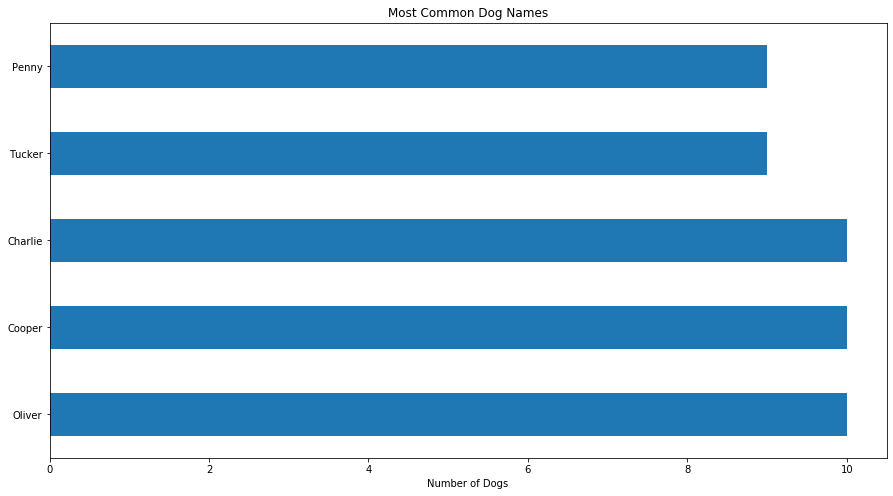

In [372]:
# Histogram to visualize dog names
df.name.value_counts()[1:6].plot('barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");

### Observation:
Oliver, Cooper and Charlie are the most tweeted dog names.

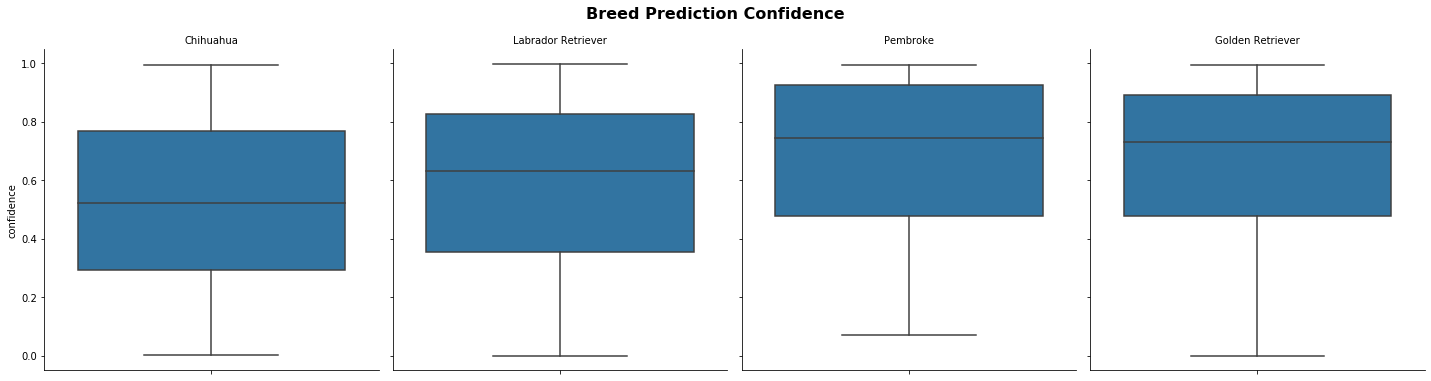

In [383]:
# create a list of top 10 names
name_list = df['breed_pred'].value_counts()[0:4].index.tolist()

# use the name_list to subset the DataFrame
df_subset = df[df['breed_pred'].isin(name_list)]

# plot a boxplot using this subset
g = sns.catplot(data=df_subset, y='pred_confidence', col="breed_pred", kind='box',sharey=True, order=type)
g.set_titles(col_template = '{col_name}')
g.set_axis_labels("", "confidence")
g.fig.suptitle('Breed Prediction Confidence', y=1.05, fontsize=16, fontweight='bold');

### Observation:
We are more confident in our prediction of certain breeds over others. For example, our prediction of a breed Golden Retriever is more confident than our prediction of a Chihuahua breed.